In this week, you are required to implement a toy GATConv and SAGEConv based on document. Also, you need to implement both in PyG and DGL. In this work, you will get a further understanding of tensor-centric in PyG and graph-centric in DGL.

</style>


## DGL

In [1]:
import os

import dgl
import dgl.function as fn
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

### GraphConv
Mathematically it is defined as follows:

$$
  h_i^{(l+1)} = \sigma(b^{(l)} + \sum_{j\in\mathcal{N}(i)}\frac{1}{c_{ji}}h_j^{(l)}W^{(l)})
$$
where $\mathcal{N}(i)$ is the set of neighbors of node $i$, 
$c_{ji}$ is the product of the square root of node degrees
$(i.e.,  c_{ji} = \sqrt{|\mathcal{N}(j)|}\sqrt{|\mathcal{N}(i)|})$,
and $\sigma$ is an activation function.

If a weight tensor on each edge is provided, the weighted graph convolution is defined as:

$$
  h_i^{(l+1)} = \sigma(b^{(l)} + \sum_{j\in\mathcal{N}(i)}\frac{e_{ji}}{c_{ji}}h_j^{(l)}W^{(l)})
$$
where $e_{ji}$is the scalar weight on the edge from node $j$ to node $i$.
This is NOT equivalent to the weighted graph convolutional network formulation in the paper.

To customize the normalization term :$c_{ji}$, one can first set ``norm='none'`` for
the model, and send the pre-normalized :$e_{ji}$ to the forward computation. We provide
:class:`~dgl.nn.pytorch.EdgeWeightNorm` to normalize scalar edge weight following the GCN paper.

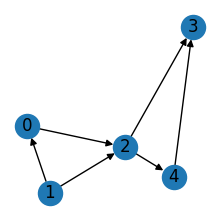

In [3]:
src = torch.tensor([0, 1, 1, 2, 2, 4])
dst = torch.tensor([2, 0, 2, 3, 4, 3])
h = torch.ones((5, 8))

g = dgl.graph((src, dst))
g.ndata["h"] = h
edge_weight = torch.ones(g.num_edges())  # 给各个边赋格权重
g.edata["edge_weight"] = edge_weight
plt.figure(figsize=(2, 2))
nx.draw(dgl.to_networkx(g), with_labels=True)

In [2]:
class DGL_GraphConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DGL_GraphConv, self).__init__()
        self.W = nn.Parameter(torch.rand(in_channels, out_channels))
        self.b = nn.Parameter(torch.rand(out_channels))
        self.activate = nn.ReLU()

    def forward(self, g, h):
        with g.local_scope():
            # 这里的normalization用了left+right，也就是考虑了出度+入度
            norm_src = g.out_degrees().clamp(min=1).view(-1, 1)
            norm_src = torch.pow(norm_src, -0.5)

            feat_src = norm_src * h
            feat_src = torch.matmul(feat_src, self.W)
            g.srcdata["h"] = feat_src
            g.update_all(fn.u_mul_e("h", "edge_weight", "he"), fn.sum("he", "rst"))
            rst = g.dstdata["rst"]

            norm_dst = g.in_degrees().clamp(min=1).view(-1, 1)
            norm_dst = torch.pow(norm_dst, -0.5)
            rst = rst * norm_dst

            rst += self.b
            return F.relu(rst)

In [4]:
in_channels = h.shape[1]
out_channels = in_channels  # *2

In [5]:
dgl_graphConv = DGL_GraphConv(in_channels, out_channels)
dgl_graphConv(g, h)

tensor([[2.9322, 3.3376, 3.0779, 3.5698, 3.4936, 3.0184, 2.9372, 3.0565],
        [0.4419, 0.9709, 0.6547, 0.4100, 0.6478, 0.7499, 0.4921, 0.3641],
        [4.6931, 5.0111, 4.7914, 5.8041, 5.5060, 4.6225, 4.6662, 4.9603],
        [4.6931, 5.0111, 4.7914, 5.8041, 5.5060, 4.6225, 4.6662, 4.9603],
        [2.9322, 3.3376, 3.0779, 3.5698, 3.4936, 3.0184, 2.9372, 3.0565]],
       grad_fn=<ReluBackward0>)

### GATConv
Graph attention layer from Graph Attention Network
$$h_i^{(l+1)} = \sum_{j\in \mathcal{N}(i)} \alpha_{i,j} W^{(l)} h_j^{(l)}$$

where $\alpha_{ij}$ is the attention score bewteen node $i$ and
node $j$:

$$
\begin{align}\begin{aligned}\alpha_{ij}^{l} &= \mathrm{softmax_i} (e_{ij}^{l})\\e_{ij}^{l} &= 
\mathrm{LeakyReLU}\left(\vec{a}^T [W h_{i} \| W h_{j}]\right)\end{aligned}\end{align}
$$

这里的 $softmax_i$ 是对节点$i$的多个边进行归一化，不考虑其他边

In [17]:
from dgl.nn.functional import edge_softmax


class DGL_GATConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DGL_GATConv, self).__init__()
        # self.W=nn.Parameter(torch.rand(in_channels,out_channels))
        # self.a=nn.Parameter(torch.rand(2*in_channels,1))
        self.W = nn.Linear(in_channels, out_channels, bias=False)
        self.a_fc = nn.Linear(out_channels * 2, 1, bias=False)
        self.leakyrelu = nn.LeakyReLU()

    def edge_attention(self, edges):
        hiW = self.W(edges.dst["h"])
        hjW = self.W(edges.src["h"])
        h_cat = torch.cat([hiW, hjW], dim=1)
        e = self.leakyrelu(self.a_fc(h_cat))
        return {"e": e}

    def forward(self, g: dgl.graph, h, get_attention=False):
        with g.local_scope():
            g.apply_edges(self.edge_attention)
            e = g.edata["e"]
            alpha = edge_softmax(g, e)
            g.edata["alpha"] = alpha
            hW = self.W(h)

            g.ndata["hW"] = hW
            g.update_all(fn.u_mul_e("hW", "alpha", "m"), fn.sum("m", "hN"))
            hN = g.ndata["hN"]

            if get_attention:
                return hN, alpha
            else:
                return hN

In [44]:
src = torch.tensor([0, 1, 1, 2, 2, 4])
dst = torch.tensor([2, 0, 2, 3, 4, 3])
h = torch.ones((5, 8))

g = dgl.graph((src, dst))
g = dgl.add_self_loop(g)
g.ndata["h"] = h
g

Graph(num_nodes=5, num_edges=11,
      ndata_schemes={'h': Scheme(shape=(8,), dtype=torch.float32)}
      edata_schemes={})

In [45]:
myGATConv = DGL_GATConv(8, 4)
torch.nn.init.ones_(myGATConv.W.weight)
torch.nn.init.ones_(myGATConv.a_fc.weight)

print(myGATConv.W.weight)
print(myGATConv.a_fc.weight)

Parameter containing:
tensor([[1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.]], requires_grad=True)
Parameter containing:
tensor([[1., 1., 1., 1., 1., 1., 1., 1.]], requires_grad=True)


In [47]:
myGATConv(g, h, get_attention=True)

(tensor([[8., 8., 8., 8.],
         [8., 8., 8., 8.],
         [8., 8., 8., 8.],
         [8., 8., 8., 8.],
         [8., 8., 8., 8.]], grad_fn=<GSpMMBackward>),
 tensor([[0.3333],
         [0.5000],
         [0.3333],
         [0.3333],
         [0.5000],
         [0.3333],
         [0.5000],
         [1.0000],
         [0.3333],
         [0.3333],
         [0.5000]], grad_fn=<EdgeSoftmaxBackward>))

In [27]:
# Case 1: Homogeneous graph
from dgl.nn import GATConv

g = dgl.graph(([0, 1, 2, 3, 2, 5], [1, 2, 3, 4, 0, 3]))
g = dgl.add_self_loop(g)

In [42]:
src = torch.tensor([0, 1, 1, 2, 2, 4])
dst = torch.tensor([2, 0, 2, 3, 4, 3])
h = torch.ones((5, 8))

g = dgl.graph((src, dst))
g = dgl.add_self_loop(g)
g.ndata["h"] = h
g

Graph(num_nodes=5, num_edges=11,
      ndata_schemes={'h': Scheme(shape=(8,), dtype=torch.float32)}
      edata_schemes={})

In [48]:
gatconv = GATConv(8, 4, num_heads=1)

torch.nn.init.ones_(gatconv.fc.weight)
torch.nn.init.ones_(gatconv.attn_l)
torch.nn.init.ones_(gatconv.attn_r)

print(gatconv.fc.weight)
print(gatconv.attn_l)
print(gatconv.attn_r)

Parameter containing:
tensor([[1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.]], requires_grad=True)
Parameter containing:
tensor([[[1., 1., 1., 1.]]], requires_grad=True)
Parameter containing:
tensor([[[1., 1., 1., 1.]]], requires_grad=True)


In [49]:
gatconv(g, h, get_attention=True)

(tensor([[[8., 8., 8., 8.]],
 
         [[8., 8., 8., 8.]],
 
         [[8., 8., 8., 8.]],
 
         [[8., 8., 8., 8.]],
 
         [[8., 8., 8., 8.]]], grad_fn=<AddBackward0>),
 tensor([[[0.3333]],
 
         [[0.5000]],
 
         [[0.3333]],
 
         [[0.3333]],
 
         [[0.5000]],
 
         [[0.3333]],
 
         [[0.5000]],
 
         [[1.0000]],
 
         [[0.3333]],
 
         [[0.3333]],
 
         [[0.5000]]], grad_fn=<EdgeSoftmaxBackward>))

In [51]:
# 完全相同耶
# (tensor([[8., 8., 8., 8.],
#          [8., 8., 8., 8.],
#          [8., 8., 8., 8.],
#          [8., 8., 8., 8.],
#          [8., 8., 8., 8.]], grad_fn=<GSpMMBackward>),
#  tensor([[0.3333],
#          [0.5000],
#          [0.3333],
#          [0.3333],
#          [0.5000],
#          [0.3333],
#          [0.5000],
#          [1.0000],
#          [0.3333],
#          [0.3333],
#          [0.5000]], grad_fn=<EdgeSoftmaxBackward>))

### SAGEConv
$$
\begin{align}\begin{aligned}
h_{\mathcal{N}(i)}^{(l+1)} &= \mathrm{aggregate}\left(\{h_{j}^{l}, \forall j \in \mathcal{N}(i) \}\right)\\\\
h_{i}^{(l+1)} &= \sigma \left(W \cdot \mathrm{concat}(h_{i}^{l}, h_{\mathcal{N}(i)}^{l+1}) \right)\\\\
h_{i}^{(l+1)} &= \mathrm{norm}(h_{i}^{(l+1)})\\\\
\mathrm{norm}(v) &= \frac{v}{\max(\lVert v \rVert_p,\epsilon)}
\end{aligned}\end{align}
$$

If a weight tensor on each edge is provided, the aggregation becomes:
$$
h_{\mathcal{N}(i)}^{(l+1)} = \mathrm{aggregate}
\left(\{e_{ji} h_{j}^{l}, \forall j \in \mathcal{N}(i) \}\right)
$$
where $e_{ji}$ is the scalar weight on the edge from node $j$ to node $i$.
    Please make sure that $e_{ji}$ is broadcastable with $h_j^{l}$.



In [ ]:
class DGL_SAGEConv(nn.Module):
    def __init__(self, in_channel, out_channel):
        pass

    def forward(self, g, h):
        pass

If you want to check your answer, you can run the following code.

In [273]:
src = torch.tensor([0, 1, 1, 2, 2, 4, 1])
dst = torch.tensor([2, 0, 2, 3, 4, 3, 3])
h = torch.ones((5, 8))
h = torch.FloatTensor(
    [
        [0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1],
        [2, 2, 2, 2, 2],
        [3, 3, 3, 3, 3],
        [4, 4, 4, 4, 4],
    ]
)

g = dgl.graph((src, dst))
g.edata["e"] = torch.ones(g.num_edges(), dtype=torch.float)
g.ndata["h"] = h
# g = g.add_self_loop()

in_channels = 5
out_channels = 7
g

Graph(num_nodes=5, num_edges=7,
      ndata_schemes={'h': Scheme(shape=(5,), dtype=torch.float32)}
      edata_schemes={'e': Scheme(shape=(), dtype=torch.float32)})

tensor([1, 0, 2, 3, 1])


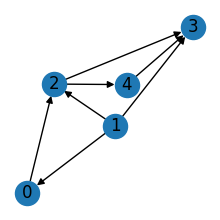

In [274]:
plt.figure(figsize=(2, 2))
nx.draw(dgl.to_networkx(g), with_labels=True)
print(g.in_degrees())

由于DGL的消息传递机制，在msg_func中传入参数为edges，通过edges.src和.dst来获取边两端的节点。
```python
def get_neighbour(edges: dgl.udf.EdgeBatch):
    hN = edges.src["h"] # 邻居
    hi = edges.dst["h"] # 自身
    h_cat = torch.cat([hi, hN], dim=1) #拼接
    # 然而这么做，当某个节点没有输入边时，自己的特征也会被设置成0
    return {"h_cat": h_cat}
```
当某个节点没有输入边时，比如上图的节点1，则在update时，msg_func中无法获取1节点自身的信息，便在reduce_func中自动将传入数据设为0。结果变为
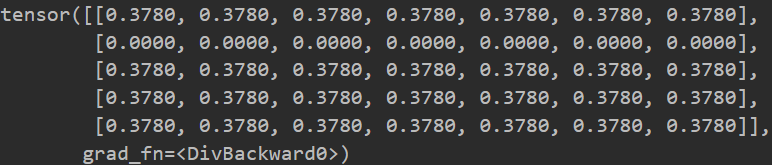

解决方式：
- 1.  增加self_loop
  2.  ```python
        g.update_all(fn.copy_u('h','tmp'),fn.sum('tmp','hN')) # 先聚合邻居
        hN=g.dstdata['hN']
        h_cat=torch.cat([hi,hN],dim=1) # 再进行拼接
        h_cat=relu(W(h_cat))
        n=F.normalize(h_cat,dim=1)
      ```
  3.  将W拆开




In [292]:
W = nn.Linear(in_channels * 2, out_channels, bias=False)
relu = nn.ReLU()
nn.init.ones_(W.weight)


def get_neighbour(edges: dgl.udf.EdgeBatch):
    hN = edges.src["h"]
    hi = edges.dst["h"]
    h_cat = torch.cat([hi, hN], dim=1)
    
    return {"h_cat": h_cat}


def reduce_func(nodes: dgl.udf.NodeBatch):
    return {}


with g.local_scope():
    hi=g.ndata['h']
    # zeros=torch.zeros_like(hi)
    # hi=torch.cat([hi,zeros],dim=1)
    g.update_all(fn.copy_u('h','tmp'),fn.sum('tmp','hN'))
    hN=g.dstdata['hN']
    h_cat=torch.cat([hi,hN],dim=1)
    h_cat=relu(W(h_cat))
    n=F.normalize(h_cat,dim=1)
    
    print(n)

tensor([[0.3780, 0.3780, 0.3780, 0.3780, 0.3780, 0.3780, 0.3780],
        [0.3780, 0.3780, 0.3780, 0.3780, 0.3780, 0.3780, 0.3780],
        [0.3780, 0.3780, 0.3780, 0.3780, 0.3780, 0.3780, 0.3780],
        [0.3780, 0.3780, 0.3780, 0.3780, 0.3780, 0.3780, 0.3780],
        [0.3780, 0.3780, 0.3780, 0.3780, 0.3780, 0.3780, 0.3780]],
       grad_fn=<DivBackward0>)


In [257]:
from dgl.nn import SAGEConv

In [258]:
sageconv = SAGEConv(
    in_channels,
    out_channels,
    aggregator_type="mean",
    bias=False,
    activation=relu,
    norm=F.normalize,
)

nn.init.ones_(sageconv.fc_neigh.weight)
nn.init.ones_(sageconv.fc_self.weight)
print(sageconv.fc_neigh.weight)
print(sageconv.fc_self.weight)

Parameter containing:
tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]], requires_grad=True)
Parameter containing:
tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]], requires_grad=True)


In [259]:
sageconv(g, h)

tensor([[0.3780, 0.3780, 0.3780, 0.3780, 0.3780, 0.3780, 0.3780],
        [0.3780, 0.3780, 0.3780, 0.3780, 0.3780, 0.3780, 0.3780],
        [0.3780, 0.3780, 0.3780, 0.3780, 0.3780, 0.3780, 0.3780],
        [0.3780, 0.3780, 0.3780, 0.3780, 0.3780, 0.3780, 0.3780],
        [0.3780, 0.3780, 0.3780, 0.3780, 0.3780, 0.3780, 0.3780]],
       grad_fn=<DivBackward0>)